# Machine Learning HW1 Simulation Part (Naive Bayes Classifier from Scratch)
## Amirmahdi Ansaripour (810198358)

## Exercise 1
### Part A: What is the main difference between Naive Bayes and Optimal Bayes classifiers? Explain what points we lose when using Naive Bayes, and when using it is reasonable.

First we should refer to Bayes Rule: $$ P(Y = y_{i} \space | \space \vec{x} ) = \frac{P(\vec{x} \space | \space Y = y_{i}) * P(Y = y_{i})}{P(\vec{x})}\quad for \quad \vec{x} = {\{x_{1},...,x_{d}}\} $$
Where $\vec{x}$ is a vector of our features, and $y_{i}$ is a label for target variable.

Based on the rule, now we can easily explain the difference:

* Naive Bayes Classifier simply assumes that features are independent, so calculating likelihood becomes much easier. In other words: 

  (Note that the denominator of Bayes rule is common among all classes, so it can be neglected)$$ {P(\vec{x} \space | \space Y = y_{i}) * P(Y = y_{i})} = {\prod_{x_{i} \epsilon \vec{x}}P(x_{i} \space | \space Y = y_{i}) * P(Y = y_{i})} $$ Based on this assumption, calcualtions are reduced significantly, regardless of how many features and classes our classification has.


* Optimal Bayes Classifier requires the distribution of likelihood, whether it is Guassian, Beta, or other types. As a result, some statistical parameters like covariance matrix of features and mean of each feature should be calculated. Not only are these calculations massive, but also we mostly do not know the exact distribution of likelihood.

* Pros and Cons of using Naive Bayes: Most of the times, features are not independent. For example, there is a direct relation between weight and age, or height. So Naive Bayes does not lead to accurate results because of its assumption of independence between features. However, due to its simplicity and low calculation costs, it is used in classification tasks frequently with approximate results.

In [15]:
import pandas as pd
import math
import numpy as np
import random
import seaborn
import matplotlib.pyplot as plt
data_path = './Data/penguins.csv'
df = pd.read_csv(data_path)
pi = math.pi
labels = ['Adelie','Chinstrap', 'Gentoo']

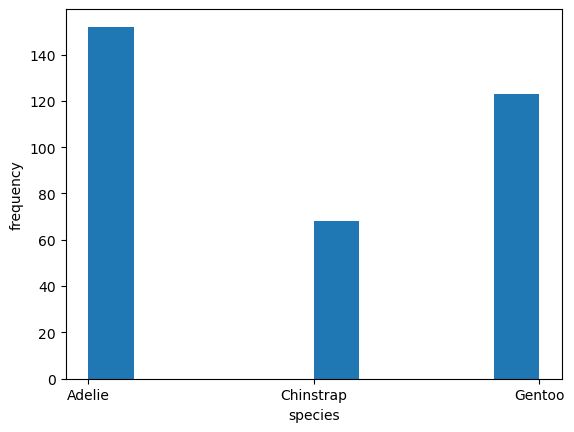

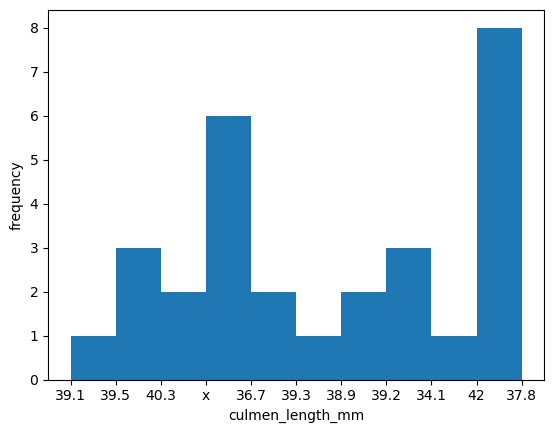

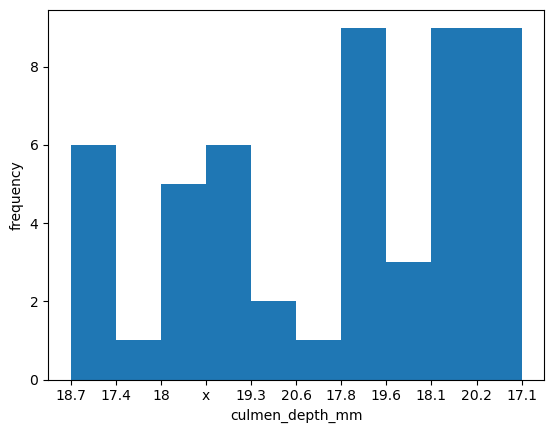

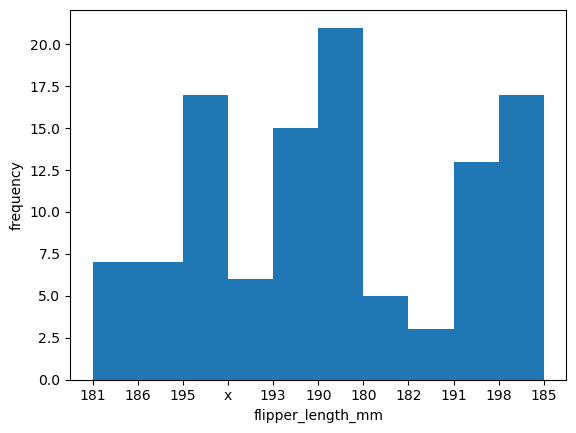

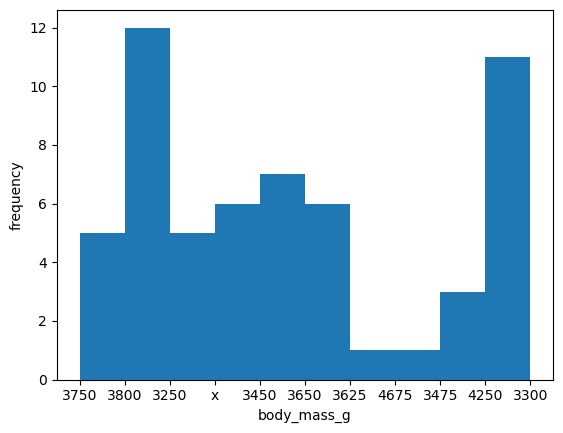

In [16]:
def showInitData(dataframe):
    columns = list(dataframe.columns)
    k = 0
    for col in columns:
        r = []
        if col == 'species':
            r = [0, 2]
        else:
            r = [0, 10]
        plt.figure(k)
        k += 1
        plt.hist(dataframe[col], range = r)
        plt.xlabel(col)
        plt.ylabel('frequency')
        plt.show

showInitData(df)


## Preprocessing 

In showDataInit function, six missing records have been detected. Two of them belong to Adelie class, one belongs to Chinstrap, and three missing recods are labeled Gentoo. Since the ratio of missing records belonging to each class, and the ratio to whole dataset is negligable (less than 5%), we can confidently omit missing data.  

In [17]:
def preprocess(dataframe):
    missing_data = []
    for col in dataframe.columns:
        missed = dataframe.index[dataframe[col] == 'x'].tolist()
        missing_data.append(missed)
    print('Missing records indexes and their labels:')
    print([missing_data[i] for i in range(1, len(missing_data))])
    print(dataframe['species'].iloc[[missing_data[1][i] for i in range(0, len(missing_data[1]))]])
    dataframe = dataframe[dataframe.culmen_length_mm != 'x']
    return dataframe
df = preprocess(df)

Missing records indexes and their labels:
[[3, 63, 170, 239, 275, 307], [3, 63, 170, 239, 275, 307], [3, 63, 170, 239, 275, 307], [3, 63, 170, 239, 275, 307]]
3         Adelie
63        Adelie
170    Chinstrap
239       Gentoo
275       Gentoo
307       Gentoo
Name: species, dtype: object


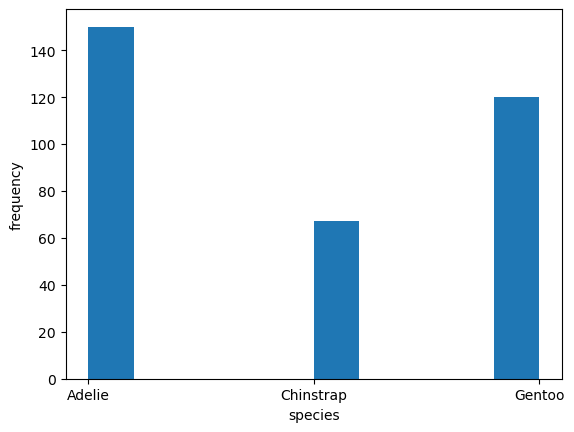

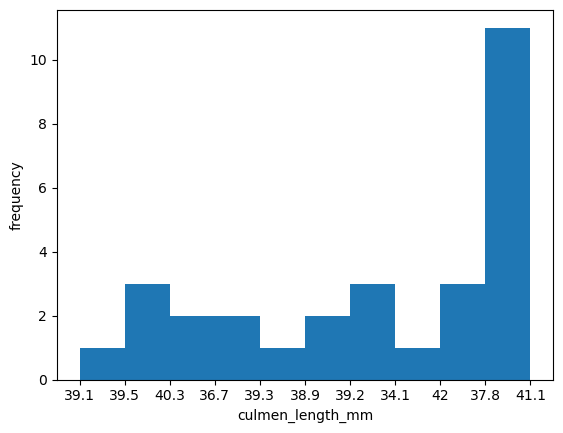

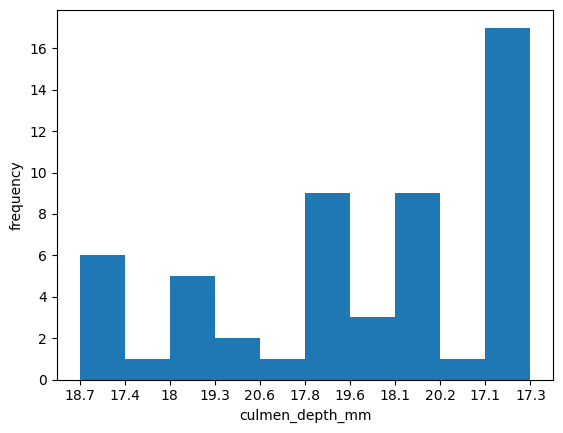

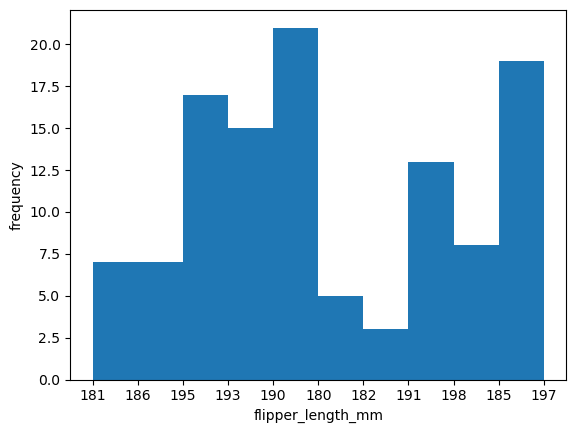

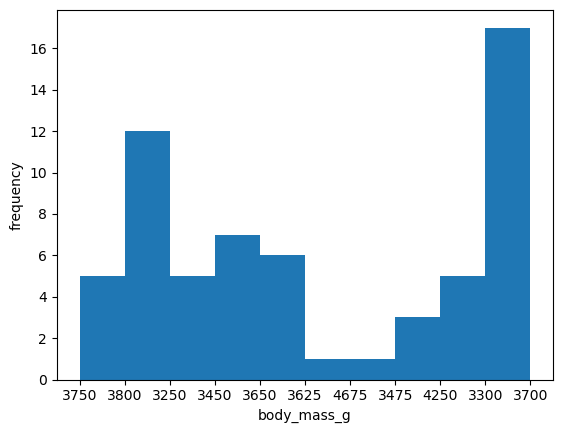

In [18]:
showInitData(df)

In [19]:
class BayesClassifier():
    def __init__(self, target_, one_vs_all):
        self.priors = [None] * 2
        self.label = one_vs_all
        self.target_col = target_
        self.features = [None] * 2

    def mean(self, samples):
        samples = [float(i) for i in samples]
        return float(sum(samples) / len(samples))

    def standardVariation(self, samples): 
        samples = [float(i) for i in samples]
        mean_ = self.mean(samples)
        diffFromMean = [(x - mean_)**2 for x in samples]
        variance = sum(diffFromMean) / float(len(samples))
        return variance
    
    def normalDistributionProb(self, newsample, avg, var):
        newsample = float(newsample)
        coeff = (math.sqrt(2 * pi * var)) ** (-1)
        exponential = float((newsample - avg)**2) / (-1 * 2 * var)
        return coeff * math.exp(exponential)
    
    def train(self, X_train, yValue):
        train_df = pd.DataFrame(X_train)
        train_df[self.target_col] = yValue
        dfclass1 = train_df.loc[(train_df['species']) == 1]
        dfclass2 = train_df.loc[(train_df['species']) != 1]
        num_of_records = len(X_train)
        self.features[1] = self.get_mean_and_stdv(dfclass1)
        self.priors[1] = len(dfclass1) / num_of_records # proportional prior probability
        self.features[0] = self.get_mean_and_stdv(dfclass2)
        self.priors[0] = len(dfclass2) / num_of_records # proportional prior probability
        
        
    def test(self, x_test):
        test_df = pd.DataFrame(x_test)
        test_samples_predict = []
        for i in range(len(test_df)):
            twoClassesProbValues = self.calcLikelihoodMultinPrior(test_df.iloc[i])
            if(twoClassesProbValues[0] > twoClassesProbValues[1]):
                test_samples_predict.append(0)
            else:
                test_samples_predict.append(1)
        return test_samples_predict



In [20]:
class NaiveBayesClassifier(BayesClassifier):
    def __init__(self, target_, on_vs_all_):
        super().__init__(target_, on_vs_all_)
    
    def get_mean_and_stdv(self, dataset):
        feature_mean_and_stdv = []
        for column in list(dataset.columns)[:-1]: 
            feature_mean_and_stdv.append([self.mean(dataset[column]), self.standardVariation(dataset[column])])
        return feature_mean_and_stdv

    def calcLikelihoodMultinPrior(self, test_sample):
        likelihoodmultinPrior = [self.priors[0], self.priors[1]]
        for classs in [0, 1]:
            features = self.features[classs]
            for i in range(len(features)):
                feature_avg, feature_stdv = self.features[classs][i][0], self.features[classs][i][1] # test_sample[i] is the value of the ith feature that test sample has 
                likelihoodmultinPrior[classs] *= self.normalDistributionProb(test_sample[i], feature_avg, feature_stdv) ## p(X|y) = p(x1|y)*...*p(xn|y)
        return likelihoodmultinPrior
        

In [21]:
def split_into_train_and_test(df, test_proportion, target_col, seed):
    random.seed(seed)
    class_indexs = []
    for target_value in ['Adelie', 'Chinstrap', 'Gentoo']:
        class_indexs.append(df.index[df[target_col] == target_value].tolist())

    train_proportion = (1 - test_proportion)
    
    train_indexs = []
    for i in range(len(class_indexs)):
        train_indexs.append(random.sample(class_indexs[i], int(train_proportion*len(class_indexs[i]))))
    
    test_indexs = []
    for i in range(len(class_indexs)):
        temp = []
        for index in class_indexs[i]:
            if index not in train_indexs[i]:
                temp.append(index)
        test_indexs.append(temp)
    
    x_train = np.array(df.iloc[:, 1:].loc[sum(train_indexs, [])]) ## The sum can also be used to concat different rows of a 
    y_train = np.array(df.iloc[:, 0].loc[sum(train_indexs, [])])  ## a multi dimensional array
    x_test = np.array(df.iloc[:, 1:].loc[sum(test_indexs, [])])
    y_test = np.array(df.iloc[:, 0].loc[sum(test_indexs, [])])
    return x_train, y_train, x_test, y_test
    
def one_vs_all_y_test(label, y_test):
    y_test_new = []
    for val in y_test:
        if(val == label):
            y_test_new.append(1)
        else:
            y_test_new.append(0)
    return y_test_new

def get_one_vs_all_result(res1, res2, res3):
    totalY_pred = []
    for j in range(len(res1)):
        if res1[j] == 1:
            totalY_pred.append('Adelie')
        elif res2[j] == 1:
            totalY_pred.append('Chinstrap')
        else:
            totalY_pred.append('Gentoo')    
    return totalY_pred

In [22]:
def printMetrics(actuals, labelss):
    accuracy = float(sum([actuals[i][i] for i in range(len(actuals))])) / (sum([sum(record) for record in actuals]))
    accuracy = round(accuracy, 3)
    precision = [None] * len(actuals)
    recall = [None] * len(actuals)
    for i in range(len(actuals)):
        precision[i] = float(actuals[i][i]) / sum([actuals[j][i] for j in range(len(actuals))])
        recall[i] = float(actuals[i][i]) / sum(actuals[i])
                
    for i in range(len(recall)):
        precision[i] = round(precision[i], 3)
        recall[i] = round(recall[i], 3)
    
    print("Accuracy of our model:\t", accuracy, '\n')
    for i in range(len(precision)):
        print("Precision for class " + labelss[i] + ":\t" + str(precision[i]))
    print('\n\n')
    for i in range(len(precision)):
        print("Recall for class " + labelss[i] + ":\t" + str(recall[i]))
    

def get_metrics(actuals, predictions, labelss):
    actualrows = [None] * len(labelss)
    for i in range(len(labelss)):
        actualrows[i] = [None] * len(labelss)
#     print(actualrows)
    actualclassIndexes = [None] * len(labelss)
    for i in range(len(labelss)):
        actualclassIndexes[i] = [j for j in range(len(actuals)) if actuals[j] == labelss[i]]
    
    for i in range(len(actualrows)):
        for j in range(len(labelss)):
            actualrows[i][j] = sum([1 for index in actualclassIndexes[i] if predictions[index] == labelss[j]])
#     print(actualrows)
    printMetrics(actualrows, labelss)
    return actualrows

def draw_confusion_matrix(actualrows, labels):
    cellcontent = [row for row in actualrows]
    table = seaborn.heatmap(cellcontent, annot = cellcontent, cmap='Blues')    
    table.set_title('Confusion Matrix\n\n')
    table.set_xlabel('\nPredicted Values')
    table.set_ylabel('Actual Values ')
    table.xaxis.set_ticklabels(labels)
    table.yaxis.set_ticklabels(labels)



In [23]:
def prepare_training_set(y_train_listed):
    y1_train = [0] * len(y_train_listed)
    y2_train = [0] * len(y_train_listed)
    y3_train = [0] * len(y_train_listed)

    for i in range(len(y_train_listed)):
        if(y_train_listed[i] == 'Adelie'):
            y1_train[i] = 1
        elif(y_train_listed[i] == 'Chinstrap'):
            y2_train[i] = 1
        elif(y_train_listed[i] == 'Gentoo'):
            y3_train[i] = 1
    return y1_train, y2_train, y3_train

## Part B: Naive Bayes from scratch (not SKlearn)

Accuracy of our model:	 0.897 

Precision for class Adelie:	0.967
Precision for class Chinstrap:	1.0
Precision for class Gentoo:	0.8



Recall for class Adelie:	0.967
Recall for class Chinstrap:	0.571
Recall for class Gentoo:	1.0


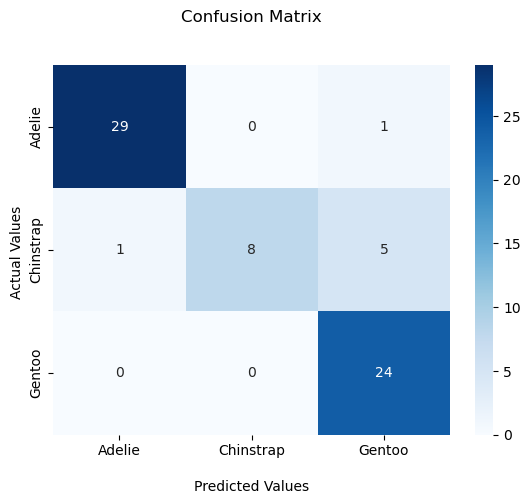

In [24]:
x_train, y_train, x_test, y_test = split_into_train_and_test(df, 0.2, 'species', 76)

y1_train, y2_train, y3_train = prepare_training_set(y_train)

model1 = NaiveBayesClassifier('species', 'Adelie')
model1.train(x_train, y1_train)
model2 = NaiveBayesClassifier('species', 'Chinstrap')
model2.train(x_train, y2_train)
model3 = NaiveBayesClassifier('species', 'Gentoo')
model3.train(x_train, y3_train)

res1 = model1.test(x_test)
res2 = model2.test(x_test)
res3 = model3.test(x_test)

totalY_pred = get_one_vs_all_result(res1, res2, res3)
actualrows = get_metrics(y_test, totalY_pred, labels)
draw_confusion_matrix(actualrows, labels)


## Analysis of model's performance

The Naive Bayes we have implemented has an accuracy of about 0.9, which means that about ninety percent of test samples have been correctly classified. 

Before disscussing other parameters for each class, I want to explain their meanings:
* Precision: This ratio shows the number of records correctly predicted A, to the whole records labeled A.
* Recall: This ratio shows the number of records correctly predicted A, to the whole records having actual value of A.  

Based on the previous defintions, we can conclude that:
* Class Adelie has high precision and recall. 

* Chinstrip class has a precision of 1, meaning all samples that we have labeled Chinstrap have the same label in reality. However, its recall is about 0.6, meaning that our model should have predicted more Chinstrap samples. This may be due to the fact that the number of Chinstrap records was not adequate in the dataset(compared to other two classes). So our model was not fed with enough Chinstrap samples in the training phase, and has acted in test phase accordingly.     

* Gentoo class's recall is 1, meaning all Gentoo samples in the real world have been correctly detected. However, the model has wrongly put Gentoo labels on some samples of other types. In other words, it has predicted Gentoo excessively, resulting in a precision of eighty percent. 

## Part C: Naive Bayes implemented using SKlearn Library (predefined)

Accuracy of our model:	 0.941 

Precision for class Adelie:	1.0
Precision for class Chinstrap:	0.929
Precision for class Gentoo:	0.889



Recall for class Adelie:	0.9
Recall for class Chinstrap:	0.929
Recall for class Gentoo:	1.0


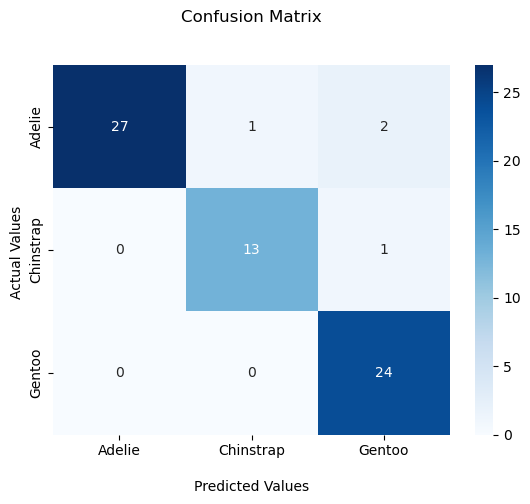

In [25]:
from sklearn.naive_bayes import GaussianNB   
from sklearn.model_selection import train_test_split
target = df.iloc[:, 0]
features = df.iloc[:, 1:]

x_train, x_test, y_train, y_test = train_test_split(features, target, stratify = target, test_size = 0.2)

y_train_listed = list(y_train)
y_test_listed = list(y_test)
y1_train, y2_train, y3_train = prepare_training_set(y_train_listed)

model1 = GaussianNB()
model2 = GaussianNB()
model3 = GaussianNB()

model1.fit(x_train, y1_train)
model2.fit(x_train, y2_train)
model3.fit(x_train, y3_train)

y1_prediction = model1.predict(x_test)
y2_prediction = model2.predict(x_test)
y3_prediction = model3.predict(x_test)

totalY_pred = get_one_vs_all_result(list(y1_prediction), list(y2_prediction), list(y3_prediction))
actualrows = get_metrics(y_test_listed, totalY_pred, labels)
draw_confusion_matrix(actualrows, labels)


## Analysis of the predifined model's performance
In generel, the predefined Naive Bayes in sklearn library had a relativly better result, compared to the one implemented from scratch. The overall accuracy is higher. But the noticeable points in the predefined model's results are the recall of Chinstrap, and precision of Gentoo. Both of these parameter have increased. In other words, the second model has predicted more Chinstraps correctly, and reduced its wrong predictions of Gentoo class.       

## Exercise 2

This classifier is used to detect whether an image describes a jungle, or a sea. The dataset is available in the folder containing this report. The decision boundry which I have defined for this classifier is based on the following rule:

$$ if(max{\{image_{green}, \space image_{red}}\} > image_{blue}) → decide \space jungle $$
$$ otherwise \quad decide \space sea $$



In [26]:
from PIL import Image
import glob

images_with_RGB = []
y_actuals = []
new_labels = ['j', 's']
Images = []
for filename in glob.glob('./Data/image/*.jpg'):
    im=Image.open(filename)
    Images.append(im)
    images_with_RGB.append(np.asarray(im))
    y_actuals.append(filename[13])


In [27]:
class image_detector_model():
    def __init__(self, images):
        self.imageSet = images
        self.eachImgRGBMean = []
        self.predictions = []
        self.fillRGBMean()
        
    def fillRGBMean(self):
        for image in self.imageSet:
            r_mean = np.sum(image[:, :, 0])
            g_mean = np.sum(image[:, :, 1])
            b_mean = np.sum(image[:, :, 2])
            self.eachImgRGBMean.append([r_mean, g_mean, b_mean])
        
    def predict(self):
#         print(np.max(self.eachImgRGBMean[0]))
        for record in self.eachImgRGBMean:
            maxColor = np.max(record)
            if maxColor > record[2]:
                self.predictions.append('j')
            else:
                self.predictions.append('s')
        return self.predictions            

Accuracy of our model:	 0.963 

Precision for class j:	0.976
Precision for class s:	0.951



Recall for class j:	0.952
Recall for class s:	0.975


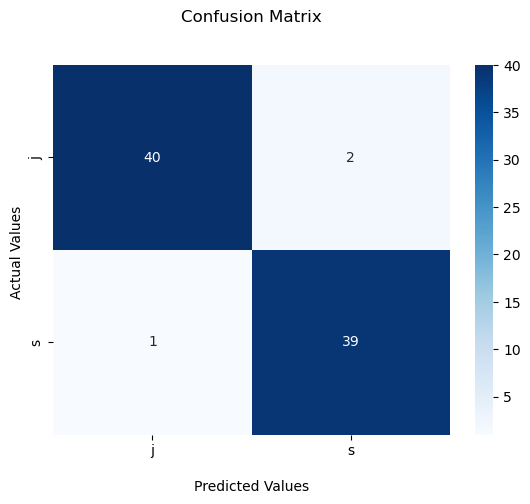

In [28]:
def get_mispredicted(y_actuals, y_predicts):
    mispredicted_samples = []
    for i in range(len(y_actuals)):
        if y_actuals[i] != y_predicts[i]:
            mispredicted_samples.append([y_actuals[i], y_predicts[i], i])
    return mispredicted_samples

def show_data_of_mispredicted(data):
    for i in range(len(data)):
        plt.figure(i)
        plt.imshow(Images[data[i][2]])
        plt.axis('off')
        title = ('predicted class: ' + data[i][1] + '\n' + 'actual class: ' + data[i][0])
        plt.title(title)        

model = image_detector_model(images_with_RGB)
y_predict = model.predict()
actualrows = get_metrics(y_actuals, y_predict, new_labels)
draw_confusion_matrix(actualrows, new_labels)

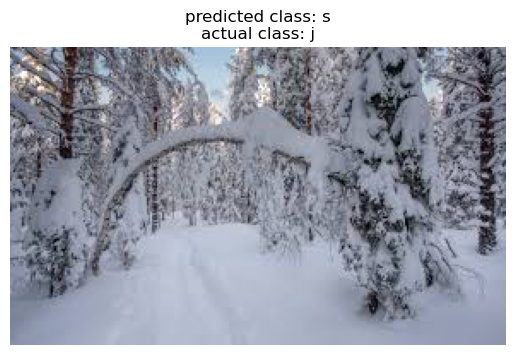

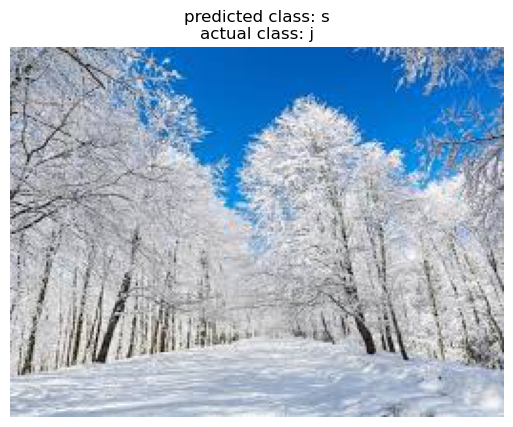

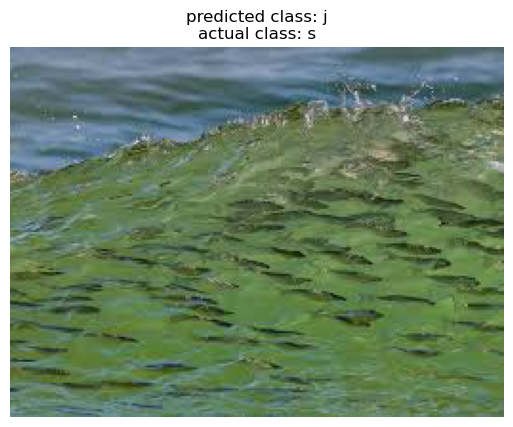

In [29]:
mispredicted_samples = get_mispredicted(y_actuals, y_predict)
show_data_of_mispredicted(mispredicted_samples)

## Explanation about mispredictions

As illustrated in the above segment, the classifier has mispredicted three images.
* The first and second images have been labeled sea, whereas they show scenes from forests in winter. The reason of misclassifion is that since the forest is covered by snow, the red (forests in authum) and green (forests in spring and summer) values of pixcels are lowered. On the other hand, the sky strenghtens the blue attribute, resulting in greater blue value and predicting sea.

* The third image is classified as a jungle, whereas it demonstrates a sea. The reason to this misclassiftion is that There is a huge green algae in the photo. As a result, the overall green value of pixcels has exceeded the blue value, and the model has missclassified a jungle accordingly. 